## Example: 2D Gaussian mixtures with NICE

2020-11-18 first created

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nice import *
from utils import *
import tensorflow as tf
print(tf.__version__)
!python --version

2.3.1
Python 3.7.6


## Settings

In [2]:
inp_dim = 2
inp_sd = 2
n_mean = 8
n_sample = 1000
radius = 10

n_couple_layer = 3
n_hid_layer = 3
n_hid_dim = 512
shuffle_type = 'reverse'
n_batch = 128
n_epoch = 3000
n_display = 500

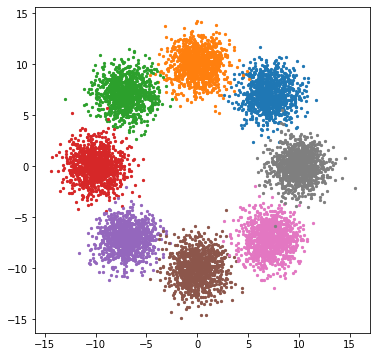

In [3]:
def make_multigauss(n_mean, n_sample, inp_dim):
    # Make multiple 2D Gaussian data samples with labels
    # output:
    # - X: 3D array (n_mean, n_sample, inp_dim)
    # - y: onehot coded (n_sample, n_mean)
    means = []
    X = np.zeros((n_mean, n_sample, inp_dim), dtype='float32')
    for m in range(n_mean):
        th = 2*np.pi/n_mean*(m+1)
        mean = [radius*np.cos(th), radius*np.sin(th)]
        X[m, :, :] = np.random.multivariate_normal(mean, np.identity(inp_dim)*inp_sd, size=n_sample)
        means.append(mean)

    #X = X_raw.reshape((-1, inp_dim))
    y = np.array([i for i in range(n_mean) for j in range(n_sample)])
    #y_onehot = np.zeros((len(y), n_mean))
    #for i in range(len(y)):
    #    y_onehot[i,y[i]] = 1    
    return X, y

X, y = make_multigauss(n_mean, n_sample, inp_dim)
fig, ax = plt.subplots(figsize=(6,6), facecolor='white')
for i in range(n_mean):
    ax.scatter(X[i,:,0], X[i,:,1], s=5)

In [4]:
def gen():
    for _ in range(n_sample):
        m = np.random.permutation(n_mean)[0]
        th = 2*np.pi/n_mean*(m+1)
        mean = [radius*np.cos(th), radius*np.sin(th)]
        X = np.random.multivariate_normal(mean, np.identity(inp_dim)*inp_sd, size=1)
        X = X.squeeze().astype('float32')
        yield (X, X)

dataset = tf.data.Dataset.from_generator(gen, (tf.float32, tf.float32), output_shapes=(inp_dim, inp_dim))        
dataset = dataset.repeat().shuffle(n_sample).batch(n_batch, drop_remainder=True)
# it = iter(dataset)
# next(it)

## Initialize the model

In [5]:
model = NICE(inp_dim, shuffle_type, n_couple_layer, n_hid_layer, n_hid_dim, name='NICE')
model.build(input_shape=(inp_dim,))
model.summary()

Model: "NICE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer0 (AdditiveCouplingLaye multiple                  526851    
_________________________________________________________________
Layer1 (AdditiveCouplingLaye multiple                  526851    
_________________________________________________________________
Layer2 (AdditiveCouplingLaye multiple                  526851    
_________________________________________________________________
scaling_layer (ScalingLayer) multiple                  2         
Total params: 1,580,555
Trainable params: 1,580,549
Non-trainable params: 6
_________________________________________________________________


In [6]:
def loss_fun(y_true, y_pred):
    # negative log likelihood
    return tf.math.reduce_sum(0.5 * y_pred **2, axis=1)

model.compile(loss=loss_fun, optimizer='adam')

## Train the model

In [7]:
%%time 
logger = NBatchLogger(n_display, n_epoch)
hist = model.fit(dataset,
                 epochs=n_epoch,
                 steps_per_epoch=1,
                 callbacks=[logger], 
                 verbose=0)

=== Started at 2020-11-19 03h:22m:46s ===
 2020-11-19 03h:22m:48s | Epoch: 1/3000 | loss=169.337448
 2020-11-19 03h:23m:20s | Epoch: 500/3000 | loss=27.236729
 2020-11-19 03h:23m:53s | Epoch: 1000/3000 | loss=13.814912
 2020-11-19 03h:24m:25s | Epoch: 1500/3000 | loss=9.538979
 2020-11-19 03h:24m:58s | Epoch: 2000/3000 | loss=7.437990
 2020-11-19 03h:25m:30s | Epoch: 2500/3000 | loss=6.801619
 2020-11-19 03h:26m:03s | Epoch: 3000/3000 | loss=6.033475
=== Time elapsed: 3.2695 min (loss:6.033475) ===
CPU times: user 5min 31s, sys: 21.2 s, total: 5min 53s
Wall time: 3min 16s


## Check results

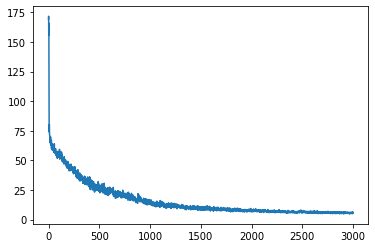

In [8]:
plt.plot(hist.history['loss'])

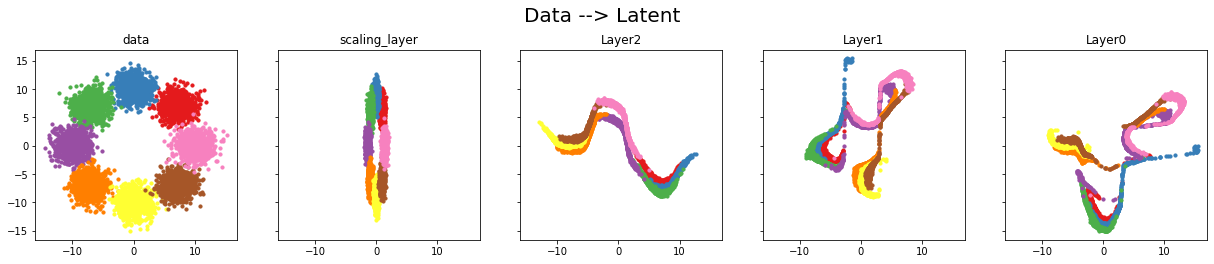

In [10]:
X, y = make_multigauss(n_mean, 1000, inp_dim)
visualize_forward_gauss(X, y, model, sharexy=True, colormap='Set1');

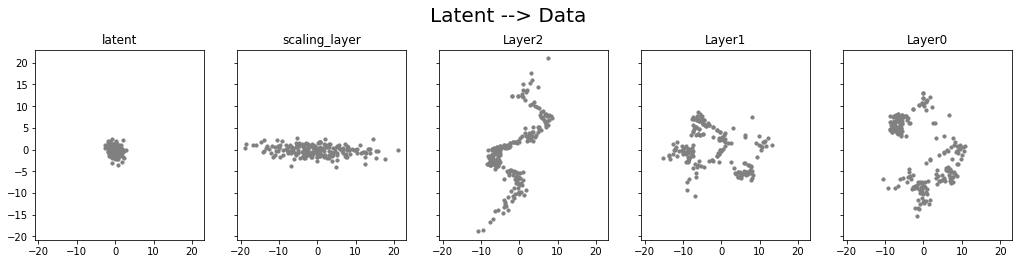

In [11]:
visualize_inverse_gauss(200, model, sharexy=True, color_list=['gray','gray','gray','gray']);